This notebook is for evaluating the model on the dataset [SEM-Dataset-500](https://github.com/motiurinfo/SEM-Dataset-500/tree/main)

- to be able to run the test, download the datset and place it in the folder 'testsets/SEM-Dataset'
- pretrained models and the utils are used from the microservice app, to gurantee the consistency.
- change the variable 'noise_level_img' to either 25 or 50

In [1]:
import os.path
import logging
import argparse

import numpy as np
from datetime import datetime
from collections import OrderedDict

import torch
import time
import sys

sys.path.append('../app/models')
import utils
from PIL import Image

In [2]:
# Assign default values to variables
model_name = 'scunet_gray_50'
testset_name = 'SEM-Dataset'
noise_level_img = 50
show_img = False
model_zoo = '../app/models/model_zoo'
testsets = 'testsets'
results = 'results'
need_degradation = True

In [3]:
n_channels = 1        # fixed, 1 for grayscale image, 3 for color image

result_name = testset_name + '_' + model_name     # fixed
border = 0            # shave boader to calculate PSNR and SSIM
model_path = os.path.join(model_zoo, model_name+'.pth')
# ----------------------------------------
# L_path, E_path, H_path
# ----------------------------------------
L_path = os.path.join(testsets, testset_name)   # L_path, for Low-quality images
H_path = os.path.join(testsets, testset_name)   # H_path, for High-quality images
E_path = os.path.join(results, result_name)     # E_path, for Estimated images
os.makedirs(E_path, exist_ok=True)

if H_path == L_path:
    need_degradation = True

need_H = True if H_path is not None else False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device, need_degradation

(device(type='cpu'), True)

In [4]:
# ----------------------------------------
# load model
# ----------------------------------------
sys.path.append('../app/models')
from SCUNET import SCUNet as net
model = net(in_nc=n_channels,config=[4,4,4,4,4,4,4],dim=64)

c:\Users\3aboo\anaconda3\envs\microscopy-service\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Blo

In [5]:
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()

C:\Users\3aboo\AppData\Local\Temp\ipykernel_2436\1840552217.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path), strict=True)


SCUNet(
  (m_head): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (m_down1): Sequential(
    (0): ConvTransBlock(
      (trans_block): Block(
        (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (msa): WMSA(
          (embedding_layer): Linear(in_features=32, out_features=96, bias=True)
          (linear): Linear(in_features=32, out_features=32, bias=True)
        )
        (drop_path): Identity()
        (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=128, out_features=32, bias=True)
        )
      )
      (conv1_1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv1_2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (conv_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), pa

In [6]:
def _test_onesplit(model, img_tensor, refield=64, min_size=256, sf=1, modulo=1):
        """
        Split the input image tensor for efficient processing and apply the model.
        """
        h, w = img_tensor.size()[-2:]

        top = slice(0, (h // 2 // refield + 1) * refield)
        bottom = slice(h - (h // 2 // refield + 1) * refield, h)
        left = slice(0, (w // 2 // refield + 1) * refield)
        right = slice(w - (w // 2 // refield + 1) * refield, w)

        Ls = [
            img_tensor[..., top, left],
            img_tensor[..., top, right],
            img_tensor[..., bottom, left],
            img_tensor[..., bottom, right],
        ]
        Es = [model(L) for L in Ls]

        b, c = Es[0].size()[:2]
        E = torch.zeros(b, c, sf * h, sf * w).type_as(img_tensor)

        E[..., : h // 2 * sf, : w // 2 * sf] = Es[0][..., : h // 2 * sf, : w // 2 * sf]
        E[..., : h // 2 * sf, w // 2 * sf : w * sf] = Es[1][..., : h // 2 * sf, (-w + w // 2) * sf :]
        E[..., h // 2 * sf : h * sf, : w // 2 * sf] = Es[2][..., (-h + h // 2) * sf :, : w // 2 * sf]
        E[..., h // 2 * sf : h * sf, w // 2 * sf : w * sf] = Es[3][..., (-h + h // 2) * sf :, (-w + w // 2) * sf :]
        return E

In [7]:
model = model.to(device)
number_parameters = sum(map(lambda x: x.numel(), model.parameters()))

test_results = OrderedDict()
test_results['name'] = []
test_results['psnr'] = []
test_results['ssim'] = []

In [8]:
def get_image_paths(dataroot):
    paths = None  # return None if dataroot is None
    if isinstance(dataroot, str):
        paths = sorted(_get_paths_from_images(dataroot))
    elif isinstance(dataroot, list):
        paths = []
        for i in dataroot:
            paths += sorted(_get_paths_from_images(i))
    return paths

IMG_EXTENSIONS = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP', '.tif']

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def _get_paths_from_images(path):
    assert os.path.isdir(path), '{:s} is not a valid directory'.format(path)
    images = []
    for dirpath, _, fnames in sorted(os.walk(path)):
        for fname in sorted(fnames):
            if is_image_file(fname):
                img_path = os.path.join(dirpath, fname)
                images.append(img_path)
    assert images, '{:s} has no valid image file'.format(path)
    return images

In [9]:
L_paths = get_image_paths(L_path)
H_paths = get_image_paths(H_path) if need_H else None

num_parameters = sum(map(lambda x: x.numel(), model.parameters()))
print('{:>16s} : {:<.4f} [M]'.format('#Params', num_parameters/10**6))

         #Params : 17.9438 [M]


In [10]:
# --------------------------------------------
# get uint8 image of size HxWxn_channles (RGB)
# --------------------------------------------
def pil2unit(path):
    img_pil = Image.open(path).convert('L')         # Convert to grayscale (uint8, 0-255)
    img_unit = np.array(img_pil, dtype=np.uint8)    # Ensure dtype matches cv2 (uint8)
    img_unit = np.expand_dims(img_pil, axis=2)      # Add channel dimension (HxWx1)
    return img_unit

In [11]:
import matplotlib.pyplot as plt
img = L_paths[0]

img_name, ext = os.path.splitext(os.path.basename(img))
img_L = pil2unit(img)


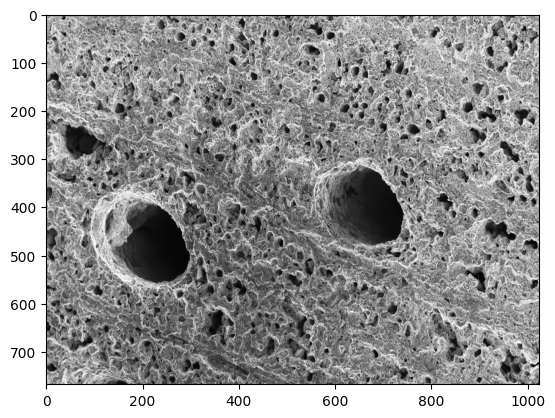

In [12]:
img_L = utils.uint2single(img_L)
plt.imshow(img_L, cmap='gray')

In [13]:
need_degradation

True

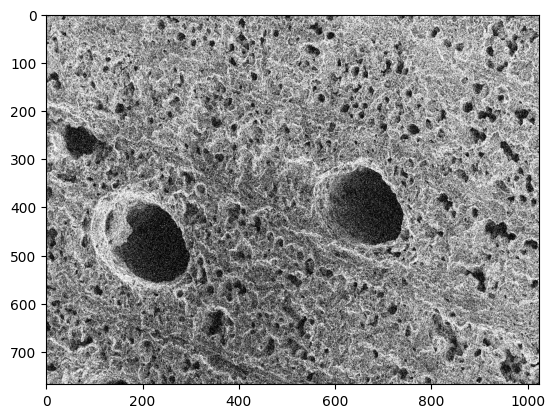

In [14]:
if need_degradation:  # degradation process
    np.random.seed(seed=0)  # for reproducibility
    img_L += np.random.normal(0, noise_level_img/255., img_L.shape)
plt.imshow(utils.single2uint(img_L), cmap='gray')

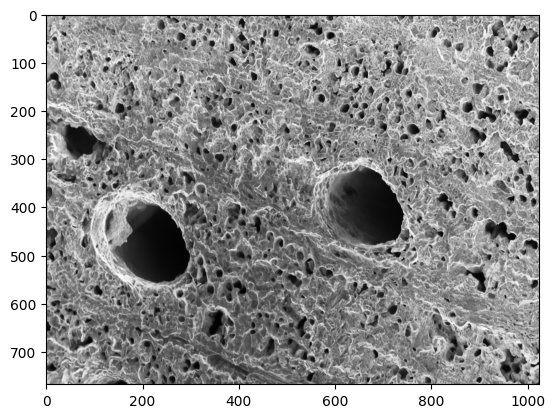

In [15]:
img_L_tensor = utils.single2tensor(img_L)
img_L_tensor = img_L_tensor.to(device)
with torch.no_grad():
    img_E = _test_onesplit(model, img_L_tensor)
img_E = utils.tensor2uint(img_E)
plt.imshow(img_E, cmap='gray')

In [19]:
import cv2
import math

def calculate_psnr(img1, img2, border=0):
    # img1 and img2 have range [0, 255]
    #img1 = img1.squeeze()
    #img2 = img2.squeeze()
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))


# --------------------------------------------
# SSIM
# --------------------------------------------
def ssim_(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

def calculate_ssim(img1, img2, border=0):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    #img1 = img1.squeeze()
    #img2 = img2.squeeze()
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    if img1.ndim == 2:
        return ssim_(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim_(img1[:,:,i], img2[:,:,i]))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim_(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')
    

def evaluate(img_E, img_H):
    img_H = img_H.squeeze()

    # --------------------------------
    # PSNR and SSIM
    # --------------------------------
    psnr = calculate_psnr(img_E, img_H, border=0)
    ssim = calculate_ssim(img_E, img_H, border=0)
    return psnr, ssim


In [22]:
import matplotlib.pyplot as plt

# Assuming util, model, etc., are already defined.
# Timing the inference
start_time = time.time()
for idx, img in enumerate(L_paths):

    img_name, ext = os.path.splitext(os.path.basename(img))
    print(img_name)
    img_H = pil2unit(img)
    img_L = img_H
    img_L = utils.uint2single(img_L)

    if need_degradation:  # degradation process
        np.random.seed(seed=0)  # for reproducibility
        img_L += np.random.normal(0, noise_level_img/255., img_L.shape)

    img_L_tensor = utils.single2tensor(img_L)
    img_L_tensor = img_L_tensor.to(device)
    with torch.no_grad():
        img_E = _test_onesplit(model, img_L_tensor)
    img_E = utils.tensor2uint(img_E)

    if need_H:
        img_H = img_H.squeeze()

        # --------------------------------
        # PSNR and SSIM
        # --------------------------------
        psnr, ssim = evaluate(img_E, img_H)
        test_results['name'].append(img_name+ext)
        test_results['psnr'].append(psnr)
        test_results['ssim'].append(ssim)

    # ------------------------------------
    # save results
    # ------------------------------------
    plt.imsave(os.path.join(E_path, img_name + ext), utils.single2uint(img_E).squeeze(), cmap='gray')
    
end_time = time.time()

print(f"Inference time: {end_time - start_time:.4f} seconds")

L0_5d5e9b4c8c55171ffe745765d259aeb5_gaussian_27.29_out
L2_9ec96c5a65980f53282ba0aaee7501c4_gaussian_26.97_out
Inference time: 46.3410 seconds


In [23]:
import csv
# Convert OrderedDict to a list of dictionaries (rows)
# Calculate the averages for 'psnr' and 'ssim'
average_psnr = sum(test_results['psnr']) / len(test_results['psnr'])
average_ssim = sum(test_results['ssim']) / len(test_results['ssim'])

# Append the 'average' row
test_results['name'].append('average')
test_results['psnr'].append(average_psnr)
test_results['ssim'].append(average_ssim)
rows = [dict(zip(test_results, t)) for t in zip(*test_results.values())]


# Define the output CSV file path
output_file = os.path.join(E_path,'results_dict.csv')

# Write the rows to the CSV file
with open(output_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=test_results.keys())
    writer.writeheader()  # Write the header (column names)
    writer.writerows(rows)  # Write the data rows